# Key values

- $\alpha_{msre}$ = 6.96e-5


# 3/29/17

For the record, there is definitely something wrong with my Jacobian because PJFNK converged WAY faster than NEWTON did. Yay for PJFNK though!

The key it turns out as always is to think carefully about what you're doing. Take one set of physics at a time. Think about what the operating temperature should be and then design the reactor dimensions to be extremeley close to critical at that temperature.

The only thing I use the `average_fission_heat` postprocessor for is as a quantity to aid in calculation of the residual for `GammaHeatSource`. Residuals are calculated with the solution variable `u`. The inner linear iteration of the Newton solve calculates $\delta u$. The $b$ vector, corresponding to $-\vec{R}(\vec{u})$, and the A matrix corresponding to $\hat{J}(\vec{u})$ doesn't change during the linear iteration. Consequently, I don't need to update that postprocessor during that time. Initial guess for $u$ for the outer Newton solve in a transient simulation is just the value of $u$ from the previous time step I would assume. And the initial guess for $\delta u$ in the inner linear iterations is zero.

The above very well may not be true. Just look at `moose-notes`. `ComputeResidualThread` is getting called during linear iterations. Also not sure whether that example in `moose-notes` was with PJFNK or with NEWTON. The residual and jacobian calling patterns are odd to me. Why would `ComputeJacobianThread` not get called any time that `ComputeResidualThread` gets called? Well at the end of a non-linear iteration, if we've reached convergence, then we have to check the residual...in that instance it makese perfect sense why we get a residual call and not a jacobian call

Ok, so for PJFNK, ComputeResidualThread is called for every linear iteration, whereas it is not called on linear iterations for NEWTON.

In [ ]:
tot_r = 60
num_segments = 30
def area(total_r, num_segments, x):
    for i in range(num_segments):
        if i == 0:
            fuel_area += 

In [ ]:
import sympy as sp

In [34]:
def calc_spacing(R, n):
    x = sp.symbols('x')
    Af = 0
    Am = 0
    for m in range(2*n - 1):
        if m % 2 == 0:
            Af += sp.pi * (R/n * (m/2 + x))**2
        if m % 2 == 1:
            Af -= sp.pi * (R/n * (m+1)/2)**2
    for m in range(2*n):
        if m % 2 == 0:
            Am -= sp.pi * (R/n * (m/2 + x))**2
        if m % 2 == 1:
            Am += sp.pi * (R/n * (m+1)/2)**2
    return sp.solve(Af / (Af + Am) - .225, x)

def intervals(R, pitch):
    return R/pitch

In [37]:
intervals(72.5, 5)

14.5

In [38]:
calc_spacing(72.5, 14)

[-13.2379522111692, 0.237952211169211]

In [28]:
n = sp.symbols('n')
sp.solve(70/n - 5, n)

[14]

- 922 K: .9648121903
- 1022 K: 0.9531920162

In [32]:
def calc_alpha(k1, k2, dT):
    average_k = (k1+k2)/2
    return (k2 - k1) / (average_k * dT * 1.8)

In [33]:
calc_alpha(.9648121903, .9531920162, 100)

-6.731635161069959e-05

Ok, using a FDP preconditioner with NEWTON, solution time is 1011.92 seconds for `transient-full-core-RZ-msre-vol-frac-and-comp-FDP.i` and the simulation requires 506 time steps. By contrast, `transient-full-core-RZ-msre-vol-frac-and-comp.i` required 2275.33 seconds and took 1052 time steps. The latter simulation employed PJFNK with SMP preconditioner.

# 3/28/17

Single channel with reflective boundary conditions (T = 922):

- H = 133 cm, k = 1.29
- H = 113, k = 1.22
- H = 75, k = .985
- H = 80, k = 1.0286
- H = 76.83486, k = 1.00165173

Now with T = 1022:

- H = 76.83468, k = 1.00282373
- T = 972, H = 76.83468, k = 1.00184445

Positive feedback; that's fantastic!!! Psych!!!

Well...I didn't have the problem set to RZ...like a big old dodo bird. So I had a much larger fuel volume fraction than I should have.

- T = 922, H = 76.83486, k = .970188376
- T = 1022, H = 76.83486, k = .956530391
- T = 1022, H = 80, k = 0.9896450276
- T = 1022, H = 81.0853, k = 1.00055746
- T = 922, H = 80, k = 1.0033598451

Annoyingly, the range of values for which a simulation is supercritical at 922 K and subcritical at 1022 K is different between k-eigenvalue and transient simulations.

In [6]:
def calc_height(h1, h2, k1, k2):
    h = sp.symbols('h')
    k = (k2 - k1) / (h2 - h1) * (h - h1) + k1

    return sp.solve(k - 1.001, h)

In [8]:
calc_height(76.83486, 80, .956530391, .9896450276)

[81.0853230182247]

In [ ]:
h1 = 75
h2 = 80
k1 = .985
k2 = 1.0286

import sympy as sp
h = sp.symbols('h')
k = (k2 - k1) / (h2 - h1) * (h - h1) + k1

sp.solve(k - 1, h)

# 3/24/17

In [1]:
cd ~/moltres_output

/home/lindsayad/moltres_output


### T = 922

In [2]:
import yt
ds = yt.load("k-eig-inverted-file-mesh-two-grp-two-mat_out.e", step=-1)
ds.parameters['eigenvalue']

array([ 1.02378742])

### T = 1022

In [3]:
ds = yt.load("inverted-temp-1022.e", step=-1)
ds.parameters['eigenvalue']

array([ 1.01036983])

Well the above is quite unfortunate :-( However, it does give us a reasonable value for the total alpha of the system:

- alpha\_moltres (with scale inputs) = 7.33e-5
- alpha\_serpent = 7.43e-5
- alpha\_msre = 6.96e-5

What's needed is a reactor that's sub-critical at 1022 K (or any value > 922 really) and very slightly super-critical at 922 K

So, heres' some resuls from the corresponding trasient simulation:

- group 1, x normal

![group_1_x](group1_x_normal_keig_1pt02.png)

- group 2, x normal

![group_2_x](group2_x_normal_keig_1pt02.png)

- group 2, z normal

![group_2_z](group2_z_normal_keig_1pt02.png)

- group 1, z normal

![group_1_z](group1_z_normal_keig_1pt02.png)

- temp, z normal

![temp_z](temp_z_normal_keig_1pt02.png)

- temp, x normal

![temp_x](temp_x_normal_keig_1pt02.png)

- temp, x normal, with mesh edges

![mesh](temp_x_normal_with_mesh.png)

Discussion: Somehow we're getting a temperature sink in the moderator regions. Looking at the mesh, it's clear that in the moderator the only nodes are on the fuel-moderator interface or in the center of the moderator. So in essence each moderator region only has two elements spanning it's width. This is a boundary layer issue. See below, corresponding to test case `simpler_test_diffusion_conservation.i`:

- initial

![initial](demo_boundary_layer_issue_step0.png)

- step

![step](demo_boundary_layer_issue_step1.png)

The above shows that if you swiftly ramp up the boundary values, the inner node un-physically decreases in value when in fact it should be increasing.

One way to solve is to just mesh it like crazy:

- 200 elements

![200](tau_1e-5_nx_200.png)

- 2000 elements

![2000](tau_1e-5_nx_2000.png)

Another thing is to increase the time scale of the transient for constant mesh size and diffusion coefficient...but that time scale is determined by physics so that's not realistic

Ok, running with a reduced height

In [4]:
ds = yt.load('k-eig-922_out.e', step = -1)
ds.parameters['eigenvalue']

array([ 1.00232862])

In [5]:
ds = yt.load('k-eig-1022_out.e', step = -1)
ds.parameters['eigenvalue']

array([ 0.98890525])

Ok, this looks like it could be a prime candidate!!

# 3/22/17

I'm going to just start including all moltres, scale, and serpent notes here, instead of having separate notebooks. 

In [13]:
k_inf_serp_msre_comp = 1.64875
k_inf_newt_msre_comp = 1.63078

Very nice comparison for the two cross section generators. These values came from `msre_single_unit_cell_res.m` and `msre_conc_cuboid_lattice/calc_buckling.out` respectively.

# 3/20/17

So the big transient simulation I ran last week, `transient-msre-file-mesh-two-grp-two-b1-mat.i` showed that it was in fact subcritical as was hoped for since the corresponding k-eigenvalue simulation was subcritical (k = .932). This corresponded to a 23x23 mesh. I'm not thrilled by the idea of making the mesh even larger...more degrees of freedom...longer run time. Unfortunatley, everything right now is educated guess-work. I think it's time to go back and look at Scale again. 

In [1]:
cd ~/moltres_output

/home/lindsayad/moltres_output


In [2]:
import yt
ds = yt.load("24x24-k-eig-two-grp-two-b1-mat_out.e", step=-1)
ds.parameters['eigenvalue']

array([ 0.95811971])

In [4]:
import sympy as sp
x, y, z = sp.symbols('x y z')
f = x*y + x*z + y*z + x**2 + y**2 + z**2

In [8]:
print(f.subs(x, 0))
print(f.subs(x, 1))
print(f.subs(y, 0))
print(f.subs(y, 1))
print(f.subs(z, 0))
print(f.subs(z, 1))

y**2 + y*z + z**2
y**2 + y*z + y + z**2 + z + 1
x**2 + x*z + z**2
x**2 + x*z + x + z**2 + z + 1
x**2 + x*y + y**2
x**2 + x*y + x + y**2 + y + 1


In [10]:
from sympy import diff

In [11]:
diff(diff(f, x), x) + diff(diff(f, y), y) + diff(diff(f, z), z)

6

In [12]:
ds26 = yt.load("26x26-k-eig-two-grp-two-b1-mat_out.e", step=-1)
ds26.parameters['eigenvalue']

array([ 1.00449883])

# 3/17/17

In [36]:
ds = yt.load("k-eig-msre-file-mesh-two-grp-two-mat_out.e", step=-1)


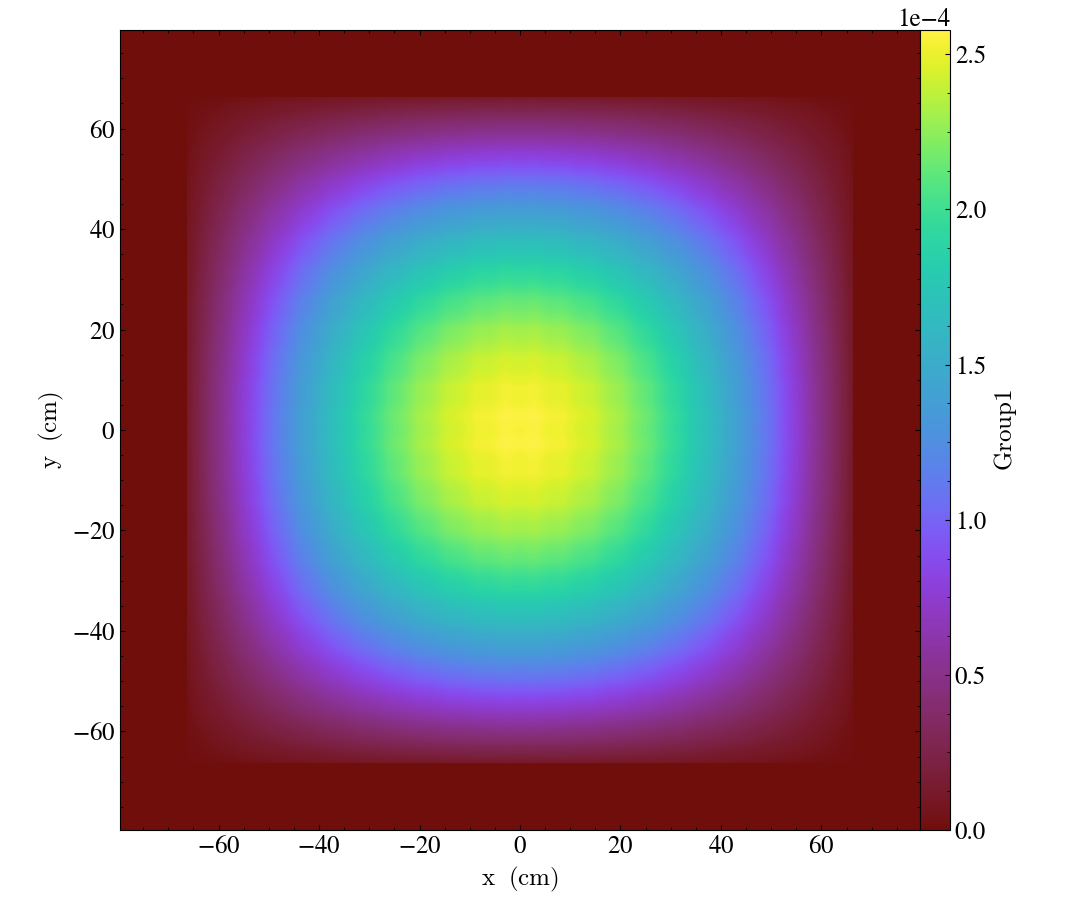

In [38]:
slc = yt.SlicePlot(ds, 'z', ('all', 'group1'), center=[63.46,63.46,81.28])
slc.set_log(('all','group1'), False)
slc.show()

In [39]:
ds.parameters['eigenvalue']

array([ 0.93209566])

# 3/16/17

Ok, so two fuel volumes along with its corresponding top and bottom are missing in the exodus rendering of the 22x22 msre mesh.

# 3/15/17

In [27]:
import yt

In [28]:
cd ~/moltres_output

/home/lindsayad/moltres_output


In [29]:
ds = yt.load("k-eig-msre-file-mesh-two-grp_out.e", step=-1)


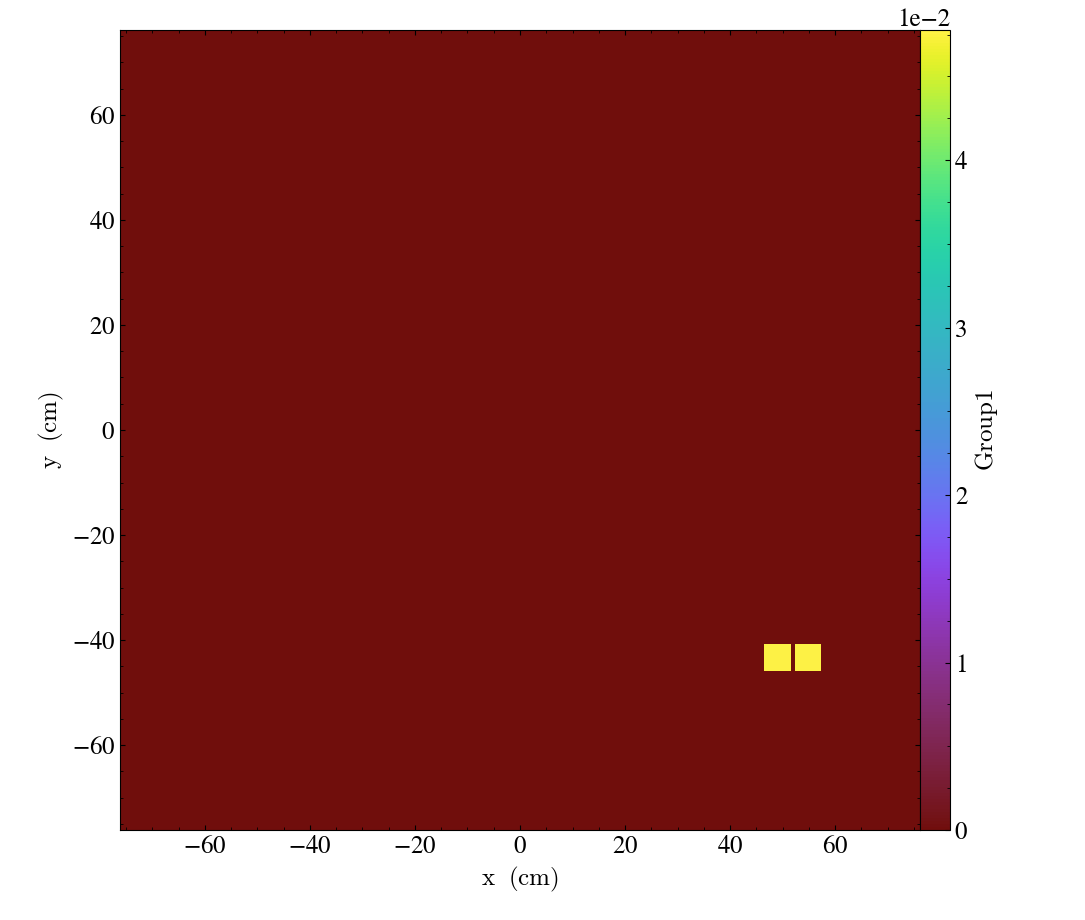

In [34]:
slc = yt.SlicePlot(ds, 'z', ('all', 'group1'), center=[60.58,60.58,81.28])
slc.set_log(('all', 'group1'), False)
slc.show()

In [30]:
ad = ds.all_data()

In [31]:
group1 = ad[('all', 'group1')]

In [33]:
group1.max()

0.04776936475558167 dimensionless

Something assymetric is definitely happening inside the above simulation.

# 3/14/17

Ok, with four groups: **k = .9950481092**. This was run with a new serpent simulation, whose corresponding analog k was .993646 and whose implicit k was .994757. This agreement is certainly good enough for me.

Summary:
- one group k = .9949941345
- two group k = .995186825
- four group k = .9950481092
- Serpent k = .994 - .995

Moreover, the Moltres two group k aligns perfectly with the analytic value calculated just from group constant cross sections output by serpent (see below).

In [10]:
nsf1 = 9.91131e-5
nsf2 = 1.49462e-3
sigma12 = 5.84977e-3
sigma21 = 9.91528e-4
sigmar1 = 6.68476e-3
sigmar2 = 2.21493e-3
k = (nsf1 + nsf2 * sigma12 / sigmar2) / (sigmar1 - sigma21 * sigma12 / sigmar2)
print(k)

0.9951862546391439


In [9]:
sigmaa1 = 8.3499e-4
sigmar1_comp = sigmaa1 + sigma12
print(sigmar1_comp)
sigmaa2 = 1.2234e-3
sigmar2_comp = sigmaa2 + sigma21
print(sigmar2_comp)

0.00668476
0.0022149279999999997


In [11]:
import netCDF4

In [12]:
cd ~/projects/moltres/problems/MooseGold/022317_test_critical_neutronics_only_reactor/

/home/lindsayad/projects/moltres/problems/MooseGold/022317_test_critical_neutronics_only_reactor


In [13]:
ds = netCDF4.Dataset("k-eig-gen-msh-inf-two-grp_out.e",step=-1)

In [23]:
for glo_var in ds.variables["name_glo_var"]:
    print(glo_var.tostring())

b'bnorm\x00\xab\xce\xdf\xea\x86,?\xa3\xab\xcf!\x92}X?\xa3\xab\xcf;\x9c0-?\xa3\xab\xcf\x89'
b'eigenvalue\x00?\xa3\xab\xcf\xfc\xb7|\x1f?\xa3\xab\xd0\x16\xc2\xac$?\xa3\xab\xd0{\xf4'
b'group1diff\x00\xa3\xab\xd1\x06\xcf/\x94?\xa3\xab\xd1 \xdc(e?\xa3\xab\xd1\x9d$\x8b'
b'group1max\x00\xa3\xab\xd2>\xce\xfe\xb8?\xa3\xab\xd2X\xdd\xf3\xe9?\xa3\xab\xd2\xeb\xa6\x19N'
b'group1norm\x00\xd3\xa3~\xbd\x03?\xa3\xab\xd3\xbd\x8f\xa5\xa4?\xa3\xab\xd4f+A\xf8?'
b'group2diff\x003{\xab\xe3?\xa3\xab\xd5M\x8d\xee\xdf?\xa3\xab\xd6\x0b=\xf6\x10?\xa3'
b'group2max\x00\xed>|\xd6?\xa3\xab\xd7\x07PB\xca?\xa3\xab\xd7\xd9H\x80E?\xa3\xab'
b'group2norm\x00\x94s?\xa3\xab\xd8\xe94B\xdf?\xa3\xab\xd9\xce\xa1\xd8\xde?\xa3\xab\xd9'
b'tot_fissions\x00\xa3\xab\xda\xf1\x8c`M?\xa3\xab\xdb\xe9S\xef\x06?\xa3\xab\xdc\x03'


In [24]:
import yt
ds = yt.load("k-eig-gen-msh-inf-two-grp_out.e", step=-1)
ad = ds.all_data()
ad[('connect1','eigenvalue')]

YTFieldNotFound: Could not find field '('connect1', 'eigenvalue')' in k-eig-gen-msh-inf-two-grp_out.e.

In [26]:
ds.parameters['eigenvalue'][0]

0.99518682522488267

So, it seems like the issue is the translation of diffusion and spatial variation from Serpent to Moltres.

I could create a single unit cell simulation in Serpent with reflective/periodic boundary conditions (note that for symmetric unit cells, reflective and periodic boundary conditions will yield the same results)...but I've already just done that. As long as there are black boundary conditions in serpent, Moltres will be unable to replicate serpent's k value.

Another thing I was thinking about: simulate single unit cell in Serpent with reflective boundary conditions. Then use B1 calculation to calculate appropriate few group constants as well as diffusion coefficients. In my initial experimentation, however, I only expect this to work when cross section homogenization is taken over the entire geometry. Consequently, I would only emerge from my Serpent simulation with group constants for a single homogenized material. How would I translate this into the temperature calculation? If I wanted to keep temperature calculation heterogeneous, in my Moltres calculation I would have to ingegrate total fission reactions over each individual unit cell and then divide by the actual unit cell fuel volume (less than the total unit cell volume obviously) to get the fission reaction rate per fuel volume. This would require assigning individual subdomain IDs to every unit cell, which kind of sounds like a lot of work. The advantage of the above method would be that I would have diffusion coefficients calculated via a deterministic method and then I could simply change my reactor dimensions in Moltres until I had a critical reactor (and hopefully those would be around the size of the MSRE reactor). Alternatively, I could just use the local fission rate in the fuel region and divide by (fuel volume/total volume)...hmmm that actually sounds like a pretty good plan!

The best case scenario is to get group constants for graphite and fuel regions. That would make life the easiest.

If using a regular lattice with radial reflective boundary conditions, then simulating just one unit cell will yield the exact same result as simulating 100x100.

**Remember**, `msre_22x22_correct_vol_fraction.msh` has 467600 nodes, so with two groups, that's 935200 degrees of freedom.

# 3/13/17

Ok, so with `022317_test_critical_neutronics_only_reactor/k-eig-gen-mesh-inf-one-grp.i`, able to get exactly the k-eigenvalue that we want: **.9949941345** which exactly equals $\frac{\bar{\nu}\Sigma_f}{\Sigma_a}$ output by serpent. Note that serpent k is **.995021**. Now I'm going to test the infinite medium, two-group formulation and make sure we still get the same k. Ok, with two group formulation, **k = 0.99518682522488267**. Next task is to see whether I can write out the analytical expression that reproduces that exact number using only the few group constants generated by serpent, analogous to what I did for the one group formulation

Whether the pressure is pinned or not, the velocity profile is identical. That's
a plus.

However, the profiles are different depending on whether the pressure is
integrated by parts or not.

So the oscillations are not caused by the convective term in the NS momentum
equation. It's definitely caused by the radial boundary condition at the axis of
symmetry.

Fantastic description of different classes of boundary conditions:
http://www.math.ttu.edu/~klong/Sundance/html/bcs.html

Well this is interesting; the _coord_type gets selected correctly when I run the
debug executable, but incorrectly when I run the opt executable.

I'm finding what Martin Leseur found: integrating p by parts creates
problems. Ok, there was a problem with the sign in the do nothing BC. When that
sign is fixed, the open flow problem is solved correctly in cartesian
coordinates whether the pressure is integrated by parts or not. The open flow
problem is solved correctly in cylindrical coordinates if the pressure is not
integrated by parts; but currently it does not converge to a solution if the
pressure is integrated by parts.

Tomorrow, record eigenvalue and flux values for different choices of the
postprocessor. Understand why the choice doesn't matter.

bxnorm = regular norm

Postprocessor Values:

| time           | bnorm          | eigenvalue     | group1max      | group1norm     | group2max      | group2norm     |
|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|   0.000000e+00 |   1.000000e+00 |   1.000000e+00 |   0.000000e+00 |   8.590069e+01 |   0.000000e+00 |   8.590069e+01 |
|   1.000000e+00 |   1.827927e+00 |   1.827927e+00 |   1.804033e-01 |   3.188402e+02 |   1.215683e-01 |   1.672426e+02 |
|   2.000000e+00 |   1.828075e+00 |   1.828075e+00 |   1.804071e-01 |   3.188541e+02 |   1.215784e-01 |   1.672560e+02 |


bxnorm = group1 norm

Postprocessor values

| time           | bnorm          | eigenvalue     | group1max      | group1norm     | group2max      | group2norm     |
|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|   0.000000e+00 |   1.164135e-02 |   1.000000e+00 |   0.000000e+00 |   1.000000e+00 |   0.000000e+00 |   1.000000e+00 |
|   1.000000e+00 |   1.049054e-02 |   1.828668e+00 |   1.034865e-03 |   1.828668e+00 |   6.967703e-04 |   9.598150e-01 |
|   2.000000e+00 |   1.048084e-02 |   1.828075e+00 |   1.034322e-03 |   1.828075e+00 |   6.970413e-04 |   9.589231e-01 |


bxnorm = group2 norm

Postprocessor Values:

| time           | bnorm          | eigenvalue     | group1max      | group1norm     | group2max      | group2norm     |
|----------------|----------------|----------------|----------------|----------------|----------------|----------------|
|   0.000000e+00 |   1.164135e-02 |   1.000000e+00 |   0.000000e+00 |   1.000000e+00 |   0.000000e+00 |   1.000000e+00 |
|   1.000000e+00 |   1.998091e-02 |   1.828113e+00 |   1.971931e-03 |   3.485134e+00 |   1.328793e-03 |   1.828113e+00 |
|   2.000000e+00 |   1.998051e-02 |   1.828075e+00 |   1.971815e-03 |   3.485013e+00 |   1.328828e-03 |   1.828075e+00 |


Notes on preconditioning:

asm-lu pre, full=false: linear its = 20
asm-lu pre, full=true: linear its = 17
default pre, full=true: linear its = 11
default pre, full=fase: linear its = 11

Ok, _grad_zero is of type std::vector<VariableGradient>. The length of the
vector is equal to the number of threads. Each element of the vector is created
like this: _grad_zero[tid].resize(getMaxQps(), RealGradient(0.));
- The type of VariableGradient is MooseArray<RealGradient>. The array has length
  equal to the number of quadrature points in the geometric element. And each
  element is of type RealGradient which is of type RealVectorValue.
- How are RealVectorValues initialized?
- RealVectorValue is of type VectorValue<Real>
- And VectorValue is a templated class

Environments for compiling on cray:

- module load cray-petsc
- module load cray-hdf5
- module switch PrgEnv-cray PrgEnv-gcc
- module load cray-mpich

So with a full preconditioner, it took 6 nonlinear iterations with PJFNK (it
does not converge with NEWTON within 50 nonlinear iterations). 7 nonlinear
iterations with just the diagonal components on the preconditioner...moreover
the number of linear iterations required was quite a bit higher. It also took 6
nonlinear iterations with line_search turned back on with PJFNK and with the
full preconditioner.

### 11/14/16

axisymm_cylinder.geo:

- H = 39.6 cm: not multiplying
- H = 80 cm; multiplying
- H = 60 cm; not multiplying
- H = 70 cm; not multiplying

There is a monotonic decrease in group 1 and group 2 fission and NSF cross sections with
increasing temperature. However, there's also a monotonic decrease in the
removal cross section as well. Diffusion constants generally trend downward with
temperature in the fuel. Same in the moderator.

Precursor1 is always the residual that causes the simulation to fail. It gets
this absolutely ridiculous depression in its concentration in the middle of the
reactor. If I look a few time steps before the simulation starts crashing, then
the precursor concentration looks like it should: monotonic. It's worthwhile to
note that precursor1 isn't the only precursor whose behavior goes from monotonic
to oscillatory; about half the precursor groups become oscillatory by the end of
failed simulations. So my job is to figure out what's going on. Why does it
crash? The problem is not:

- the RZ formulation
- the precursor decay kernels

The problem can't be fixed by:
- just reducing the advection velocity
- changing prec scaling from 1e-3 to 1e3
- increasing artificial diffusion

When the precursor simulation fails, the temperature and flux profiles look
fine.

Can definitely fix it with a sufficient source stabilization...but then the
problem becomes accuracy.

Order of tasks:

deprecated_block
finish_input_file_output
meta_action
no_action
setup_oversampling

Order of tasks that do things:
- dynamic_object_registration
    - Problem
- common_output
    - Outputs
- set_global_params
    - GlobalParams
- setup_recover_file_base
- check_copy_nodal_vars
    - temp
- setup_mesh
    - Mesh


So it makes sense that it takes so much bloody time for heat to diffuse from the
surface of the moderator into the moderator bulk. The charateristic diffusion
time from interface to wall is 42 seconds. The massive amounts of heat from
fission are being generated over the course of hundredths of a second. So yea
we're going to have to go to some wall like condition at the interface...e.g. we
cannot have Tmod = Tfuel at the interface.

Coefficient of thermal expansion, graphite: 2-6e-6 m/(m*K)

Doubling fluid flow velocity (see leastSquared directory), had absolutely no
impact on the maximum temperature in the reactor which seems a little bit odd to
me.

Putting those dumb boundary conditions in place for the temperature in the
moderator produces a hideous spectrum. I think how Cammi got around these things
is because he never used local temperatures to determine his properties. He used
block averaged values. So he could integrate over half the moderator domain to
determine the average temperature and then use that for the neutron group
constants in the other half.

Working on monotone cubic interpolation:

The second order accurate finite difference methods for derivative computation
will compute derivatives exactly for a second order polynomial. They WILL NOT
correctly compute derivatives for a third order polynomial because they are only
second order accurate. The FC algorithm initializes derivatives using this
second order differencing scheme. However, the FB algorithm roughly averages
neighboring secant lines...this is not second order accurate (or is it?).

Let's say we have some function. We want to evaluate/estimate it's derivative at
a point. How can we do that? We can perform a finite difference to do the
estimation:

f'(x) ~ (f(x+h) - f(x-h)) / h

We can write the error of this approximation as:

E(h) = C * h**n

where n is the order of accuracy. We can imagine a case where a method is nth
order accurate and the error is zero; this corresponds to C = 0.

From wikipedia: "The Newton series consists of the terms of the Newton forward
difference equation, named after Isaac Newton; in essence, it is the Newton
interpolation formula, namely the discrete analog of the continuum Taylor
expansion, which holds for any polynomial function f and for most (but not all)
analytic functions.

You can define your numerical derivative however you want! But then the key is
you need to be able to set-up an expression:

y' + Error(stuff, h) = numerical\_derivative

And then you can inspect the parts that make up the error in order to determine
it's functional dependence on h and perhaps whether the error is zero because of
other components that make up the error function. Cool!

yt is not correctly rendering any of my new neutronic simulation data sets! Need
to figure out why.

Ok first test was running a single region test with Quad4 elements. That test
went sucessfully which makes sense because Andrew has had a Q2 sampler
implemented forever.

It should be noted that data values in yt aren't actually accessed until
performing data access, something like `ad['diffused']`. Even this operation:
`ad = ds.all_data()` won't actually read the variable values.

Prism volumes:
second order volumes: 1.17718
first order volumes: 1.06066

For just one element:
first order volume: 1.5 (as it should be)
second order volume: 2.32843; very close to 2.356 which is equal to:
pi * r^2 * h / 4

The rule for computing the PRISM18 volume can be found in the libmesh source.

The natural boundary condition appears to have an effect on the flow at the
boundary for shizzle.

I've been able to get the flow simulation to work perfectly with the correct
geometry and the correct boundary conditions. Nice!

Ok, so when linking a library with -l, the linker searches in order from first
to last of directories provided with -L. -rpath matters for run-time; if there's
a mistake in supplying rpath during the linking stage, this error will show up
at run-time, NOT during program linking.

ldd uses LD_LIBRARY_PATH. You can kind of think of ldd as a command that
executes the shared object in order to discover its dependencies. Things that
get executed care about their environment; e.g. in this case ldd certainly cares
about LD_LIBRARY_PATH.

Changing LD_LIBRARY_PATH will change the memory location/library version that a
shared object points to. E.g. if I alter LD_LIBRARY_PATH, then I can change the
location of the library that libgfortran.so.3 points to.

When resolving shared object dependencies of an executable or other shared
object, the looking order is roughly the following:

1. Directories specified in the DT_RPATH dynamic section attribute of the
   executable/shared object in question (this is set at compile/linking time for
   example with -W,-rpath)
2. From the environment variable LD_LIBRARY_PATH
3. From the library directories listed in /etc/ld.so.conf
4. Finally in /lib and then /usr/lib

Nice!

The problematic file appears to be...kind of the core shared
object...libmesh_dbg.so

Successfull compilation command for the previously failing unit_tests-dbg:

ccache clang++ -std=gnu++11 -O0 -felide-constructors -g -pedantic -W -Wall
-Wextra -Wno-long-long -Wunused -Wpointer-arith -Wformat -Wparentheses
-Qunused-arguments -Woverloaded-virtual -fopenmp -std=gnu++11 -o
.libs/unit_tests-dbg hello.cpp -Wl,-rpath -Wl,/opt/moose/tbb/lib -Wl,-rpath
-Wl,/opt/moose/petsc/mpich_petsc-3.7.4/clang-opt-superlu/lib -Wl,-rpath
-Wl,/opt/moose/gcc-6.2.0/lib/gcc/x86_64-pc-linux-gnu/6.2.0 -Wl,-rpath
-Wl,/opt/moose/gcc-6.2.0/lib64 -Wl,-rpath -Wl,/lib/x86_64-linux-gnu -Wl,-rpath
-Wl,/opt/moose/gcc-6.2.0/lib -Wl,-rpath
-Wl,/opt/moose/mpich/mpich-3.2/clang-opt/lib -Wl,-rpath
-Wl,/opt/moose/llvm-3.9.0/lib -Wl,-rpath -Wl,/usr/lib/x86_64-linux-gnu
-L/opt/moose/petsc/mpich_petsc-3.7.4/clang-opt-superlu/lib
-L/opt/moose/mpich/mpich-3.2/clang-opt/lib -L/opt/moose/gcc-6.2.0/lib64
-L/opt/moose/gcc-6.2.0/lib
/home/lindsayad/test_multiple_petsc/libmesh/build/contrib/netcdf/v4/liblib/.libs/libnetcdf.so
/usr/lib/x86_64-linux-gnu/libcurl-gnutls.so -lz -L/opt/moose/tbb/lib -ltbb
-ltbbmalloc -lpetsc -lsuperlu_dist -lcmumps -ldmumps -lsmumps -lzmumps
-lmumps_common -lpord -lparmetis -lmetis -lHYPRE
-L/opt/moose/gcc-6.2.0/lib/gcc/x86_64-pc-linux-gnu/6.2.0 -L/lib/x86_64-linux-gnu
-L/opt/moose/llvm-3.9.0/lib -lscalapack -lflapack -lfblas -lX11 -lhwloc
/opt/moose/mpich/mpich-3.2/clang-opt/lib/libmpifort.so
/opt/moose/gcc-6.2.0/lib/../lib64/libgfortran.so
/opt/moose/gcc-6.2.0/lib/../lib64/libgomp.so
/opt/moose/gcc-6.2.0/lib/../lib64/libquadmath.so
/opt/moose/mpich/mpich-3.2/clang-opt/lib/libmpicxx.so
/opt/moose/gcc-6.2.0/lib/../lib64/libstdc++.so -lm
/opt/moose/mpich/mpich-3.2/clang-opt/lib/libmpi.so -lrt -lomp -lgcc_s -lpthread
-L/usr/lib/x86_64-linux-gnu -L/opt/moose/cppunit-1.12.1/clang-opt/lib -lcppunit
-ldl -pthread -fopenmp -Wl,-rpath
-Wl,/home/lindsayad/test_multiple_petsc/scripts/../libmesh/installed/lib
-Wl,-rpath -Wl,/opt/moose/gcc-6.2.0/lib/../lib64 -Wl,-rpath
-Wl,/opt/moose/mpich/mpich-3.2/clang-opt/lib

Should it be enough...?

I learned exactly why the libmesh build was failing. The reason is that when
compiling and linking the libmesh_dbg library, the /usr/lib/x86_64-linux-gnu
directory was passed to the linker before the opt petsc directory, meaning that
-lpetsc links in the system petsc as opposed to the MOOSE environment petsc. And
then when compiling and linking the unit_tests-dbg shared object, the opt petsc directory
is passed first, so there's a mismatch there.

To summarize: system petsc can be used to build libmesh/moose as long as the
moose environment is not loaded. However, it's pretty much impossible to unload
the system packages, so the moose environment petsc cannot be used to build
libmesh/moose as long as the system petsc is installed.

Knowing why this failed is enough for me. There's really no practical use to
having two petsc installations loaded at any time.

Cannot source .bashrc when a conda virtualenv is active.

In typedef:

typedef <ITEM1> <ITEM2>

The second item is being defined to equal the first item, e.g., you can think of
it as:

ITEM2 = ITEM1

e.g. ITEM1 is the thing that already exists.

Looking at dof_map_constraints.C in libMesh:

During interpolation of the nodes, these dofs get fixed:

first element (0xa74eb0):
0
1
3
4
7
This must be a corner element of the global mesh

second element (0xa75020):
0
1
4
This must be a side element of the global mesh

So question is: how is it determined whether a degree of freedom is nodal or edge? A reasonable guess would be that a "nodal" degree of freedom corresponds to an element vertex.

Another question: why is it that on edge dofs the solution values aren't simply assigned to the evaluation of the dirichlet function?

On a quadrilateral side (with second order shape functions), there are three quadrature points. I'm curious where the quadrature points are located.

Ok, stripping the problem down to one element. Then the quadrature points of one example side are:

(-.77, -1, 0)
(0, -1, 0)
(.77, -1, 0)

Which of these also corresponds to a degree of freedom?? Why the point (0, -1, 0) does of course.

Solution value at (-.77, -1, 0): -.3467

Ok the solution values at the quadrature points calculated in libmesh match the dirichlet function being projected onto them. That's good!

I need to understand what an infinite homogeneous medium really means in the context of Scale.

Files that cause compilation errors during Scale build:

packages/Tsurfer/read_npt.f90:1552
packages/Senlib/read_response_M.f90:277
packages/Senlib/read_response_M.f90:394

Trying to get familiar with Scale execution. Currently performing an infinite lattice calculation with NEWT (sample newt1.inp).

Call sequence so far:

main (ScalePrograms/scale.cpp)
Scale::ScaleDriver::run (ScaleDriver/ScaleDriver.cpp)
Scale::ScaleDriver::runSequence (ScaleDriver/ScaleDriver.cpp)
Scale::Sequence::TNewt::execute (Sequence/TNewt/TNewt.cpp)
Scale::Module::BaseTMGTransport::execute (Module/Xsdrn/BaseTMGTransport.cpp)
Scale::Module::XSProcModule::execute (Module/XSProc/XSProcModule.cpp)

From whithin XSProceModule::execute we call:

Crawdad::execute (Crawdad/Crawdad.cpp)

amd then:

XSProc::execute (XSProc/XSProc/XSProc.cpp)

From within XSProc::excute we call:

Dancoff::execute (XSProc/dancoff/Dancoff.cpp)
execute_dancoff (XSProc/dancoff/DancoffInterface.cpp)
F_executeDancoff (XSProc/dancoff/Dancoff_I.f90)
execute_dancoff (XSProc/dancoff/Dancoff_M.f90)

and then:

bonamiM::execute (XSProc/bonamiM/nonamiM.cpp)

and then:

MixMacros::execute (XSProc/MixMacros/MixMacros.cpp)

and then:

CentrmPmc::execute (PMC/CentrmPmc.cpp)

and then:

MixMacros::execute

Once all that is finished we return to Scale::Module::BaseTMGTransport::execute (BaseTMGTransport.cpp) which then calls:

Scale::Module::NewtModule::execute (Module/Newt/NewtModule.cpp)

BaseTMGTransport::execute looks like an important function. It is the function from which both the execution routines for generating the multigroup cross sections and the actual transport code are called.

Here's Newt backtrace:

#0  newtapifortran_m::executenewt (inputsaver=..., lib=...)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/Newt/NewtApiFortran.f90:184
#1  0x00007fffe8673d47 in newtapibinding_m::f_executenewt (
    inputsaver=<error reading variable: Attempt to dereference a generic pointer.>,
    libs=<error reading variable: Attempt to dereference a generic pointer.>)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/Newt/NewtApiBinding.f90:38
#2  0x00007ffff2b88d0b in NEWT::NewtApi::executeNewt (this=0x7fffffffc130, inputSaver=0x5db0718, lib=0x238af770)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/Newt/NewtApi.h:41
#3  0x00007ffff2b85689 in Scale::Module::NewtModule::execute (this=0x5db0660)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/Module/Newt/NewtModule.cpp:212
#4  0x00007ffff293932b in Scale::Module::BaseTMGTransport::execute (this=0x68f710)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/Module/Xsdrn/BaseTMGTransport.cpp:174
#5  0x00007ffff7206c94 in Scale::Sequence::TNewt::execute (this=0x68f470)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/Sequence/TNewt/TNewt.cpp:200
#6  0x00007ffff7bc16a3 in Scale::ScaleDriver::runSequence (this=0x7fffffffd620, name=..., sequence=..., current_sequence_stream=...)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/ScaleDriver/ScaleDriver.cpp:591
#7  0x00007ffff7bbfe6c in Scale::ScaleDriver::run(Standard::Factory<Standard::AbstractSequence*, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::function<Standard::AbstractSequence* ()> >&) (this=0x7fffffffd620, sequenceFactory=...)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/ScaleDriver/ScaleDriver.cpp:389
#8  0x000000000041919f in main (argc=2, argv=0x7fffffffd908)
    at /home/lindsayad/scale/SCALE-6.2-serial-6.2.1-Source/packages/ScalePrograms/scale.cpp:173

Now looking at executing my silly little input file.

Still call Crawdad and then again:

Dancoff
Bonami
MixMacros
CentrmPmc
MixMacros

Drilling down a little into centrmpmc.

Crawdad gets called according to the documentation because CentrmPmc requires it (or something like that).

Ok, using an infinite lattice as opposed to inifinite homogeneous medium, I still get high k values:

k-eff = 1.41823805
k-infinity from four factor formula = 1.419670

After "Critical Spectra Calculated with the B1 Method":

Critical Buckling = 1.05846e-3
k-infinity of critical system = 1.38594

Changing the grid size from 5x5 to 10x10 (at least I believe that's what I was doing) did not appreciably change the results.

## 1/11/17

Trying to understand what nodal methods means. Here are some excerpts from <i>Progress in Nodal Methods for the Solution of the Neutron Diffusion and Transport Equations</i> written by Lawrence, published in 1985:

> "Practical limiations on computer storage and execution time generally prohibit the explicit modeling of each fuel pin in a LWR. Instead 'equivalent' few-group diffusion-theory parameters are determined for relatively large homogeneous regions often consisting of entire fuel assemblies in the radial plane. With these parameters in hand, global solutions are computed for this homogenized-assembly representation of the reactor. Solution of this problem using traditional finite-difference techniques requires a large number of mesh points in orrder to represent accurately the spatial variation of the neutron flux. The computational expense associated with these calculations motivated the early development of less rigorous, yet more computationally efficient techniques oriented towards the determination of the flux averaged over each homogeneous region or 'node'. This class of methods thus became known as nodal methods, and the FLARE model developed in 1964 is representative of the first generation of these schemes."


In [2]:
sigma_t_1 = 3.05946e-1
sigmas_1to1 = 2.94802e-1
sigmas_1to2 = 1.94277e-3
sigmas_1 = sigmas_1to1 + sigmas_1to2
sigma_a_1 = sigma_t_1 - sigmas_1
print(sigmas_1)
print(sigma_a_1)

0.29674477
0.009201230000000005


In [4]:
sigma_t_2 = 3.15036e-1
sigma_s_2to1 = 1.58033e-3
sigma_s_2to2 = 2.76692e-1
sigma_s_2 = sigma_s_2to1 + sigma_s_2to2
sigma_a_2 = sigma_t_2 - sigma_s_2
print(sigma_s_2)
print(sigma_a_2)


0.27827233
0.03676366999999997


Alright, confirmed that we can deduce the `Total- Scatter` cross section (equivalent to what I am used to thinking of as the absorption cross section) from summing the contributions of the P0 scattering matrix. Good!

## 1/12/17

Trying to figure out how to pass default coupling values through to actions:

```C++
void
InputParameters::addCoupledVar(const std::string & name, const std::string & doc_string)
{
  addParam<std::vector<VariableName> >(name, doc_string);
  _coupled_vars.insert(name);
}

Ok, we're passing T = std::vector<VariableName> >

template <typename T>
void
InputParameters::addParam(const std::string &name, const std::string &doc_string)
{
  checkConsistentType<T>(name);

  InputParameters::insert<T>(name);
  _doc_string[name] = doc_string;
}

Recall again, T = std::vector<VariableName> >

template <typename T>
inline
void Parameters::insert (const std::string & name)
{
  if (!this->have_parameter<T>(name))
    _values[name] = new Parameter<T>;

  set_attributes(name, true);
}

Note that the if block in the above function does get entered as one might hope.

So in compilation, what does that code pattern look like?

  checkConsistentType<T>(name);
  
  if (!this->have_parameter<T>(name))
    _values[name] = new Parameter<T>;

  set_attributes(name, true);
  _doc_string[name] = doc_string;
  
  _coupled_vars.insert(name);  
  
Hmm, that's interesting, here's what InputParameters::set looks like:

  checkConsistentType<T>(name);

  if (!this->have_parameter<T>(name))
    _values[name] = new Parameter<T>;

  set_attributes(name, false);

  if (quiet_mode)
    _set_by_add_param.insert(name);

  return cast_ptr<Parameter<T>*>(_values[name])->set();
  
```

It's important to note that we are setting to a `getParam`

```
getVecMooseTypes searches itself for a parameter with name "name". If it finds that parameter, then it tries to get the vector of variable names accessible by name. 

Parameters::_values is a map. It's like a python dictionary. It's keys are the parameter names. And then each key has an associated value which can be of a variety of types. Apparently the key "temperature" is associated with a vector of VariableNames. And in the normal Kernel case, when acessing the value corresponding to the key name of "v", the value returned is essentially NULL. How come that doesn't happen for me??? My question is: when does the value part of the key-value pair get added to the map??

In Coupleable, we loop from _c_parameters.coupledVarsBegin() to _c_parameters.coupledVarsEnd() which just inspects _coupled_vars. _coupled_vars itself is set of strings, e.g. it's a set of the coupled variable names.

So as already discussed, one of my big issues is that I have no idea at what point the value part of the key-value pair for "temperature" gets created.
```

```
Apparently cast_ptr is a type definied by libmesh. Knew it!
```

```
Here's default temperature of 800:

+----------------+----------------+----------------+----------------+
| time           | group1_current | group1_old     | multiplication |
+----------------+----------------+----------------+----------------+
|   0.000000e+00 |   0.000000e+00 |   0.000000e+00 |   0.000000e+00 |
|   1.000000e-04 |   3.539391e+03 |   1.328831e+03 |   2.663538e+00 |
|   2.200000e-04 |   3.186612e+03 |   3.539391e+03 |   9.003279e-01 |
|   3.640000e-04 |   2.307495e+03 |   3.186612e+03 |   7.241216e-01 |
|   5.368000e-04 |   1.524371e+03 |   2.307495e+03 |   6.606172e-01 |
|   7.441600e-04 |   9.246172e+02 |   1.524371e+03 |   6.065567e-01 |
|   9.929920e-04 |   5.076227e+02 |   9.246172e+02 |   5.490085e-01 |
|   1.291590e-03 |   2.472787e+02 |   5.076227e+02 |   4.871309e-01 |
+----------------+----------------+----------------+----------------+

Here's default temperature of 1050:

Postprocessor Values:
+----------------+----------------+----------------+----------------+
| time           | group1_current | group1_old     | multiplication |
+----------------+----------------+----------------+----------------+
|   0.000000e+00 |   0.000000e+00 |   0.000000e+00 |   0.000000e+00 |
|   1.000000e-04 |   3.539391e+03 |   1.328831e+03 |   2.663538e+00 |
|   2.200000e-04 |   3.186612e+03 |   3.539391e+03 |   9.003279e-01 |
|   3.640000e-04 |   2.307495e+03 |   3.186612e+03 |   7.241216e-01 |
|   5.368000e-04 |   1.524371e+03 |   2.307495e+03 |   6.606172e-01 |
|   7.441600e-04 |   9.246172e+02 |   1.524371e+03 |   6.065567e-01 |
|   9.929920e-04 |   5.076227e+02 |   9.246172e+02 |   5.490085e-01 |
|   1.291590e-03 |   2.472787e+02 |   5.076227e+02 |   4.871309e-01 |
+----------------+----------------+----------------+----------------+

The exact frieking same.

With the default temperatures changed in the kernel source files:

Postprocessor Values:
+----------------+----------------+----------------+----------------+
| time           | group1_current | group1_old     | multiplication |
+----------------+----------------+----------------+----------------+
|   0.000000e+00 |   0.000000e+00 |   0.000000e+00 |   0.000000e+00 |
|   1.000000e-04 |   3.539391e+03 |   1.328831e+03 |   2.663538e+00 |
|   2.200000e-04 |   3.186612e+03 |   3.539391e+03 |   9.003279e-01 |
|   3.640000e-04 |   2.307495e+03 |   3.186612e+03 |   7.241216e-01 |
|   5.368000e-04 |   1.524371e+03 |   2.307495e+03 |   6.606172e-01 |
|   7.441600e-04 |   9.246172e+02 |   1.524371e+03 |   6.065567e-01 |
|   9.929920e-04 |   5.076227e+02 |   9.246172e+02 |   5.490085e-01 |
|   1.291590e-03 |   2.472787e+02 |   5.076227e+02 |   4.871309e-01 |
+----------------+----------------+----------------+----------------+

The exact frieking same. There's some weird stuff going on right now, and I'm too tired to debug it.

Well I figured out why this wasn't changing...the temperature is not used in any of the kernel calculations. It's only used in the material calculation and that has a default setting itself which was totally unaffected by any temperature changes I was trying to affect in the action.
```

I'm a glutton for punishment, what can I say.

```
params.addCoupledVar gets called before InputParameters::defaultCoupledValue which actually sets the default coupled value.

Here's the latter's backtrace:

#0  InputParameters::defaultCoupledValue (this=0xa2db98, coupling_name=..., value=3)
    at /home/lindsayad/projects/moose/framework/src/utils/InputParameters.C:426
#1  0x00007ffff66d9c57 in Parser::setVectorParameter<VariableName> (this=0x9db9e0, full_name=..., short_name=..., param=0xa30070)
    at /home/lindsayad/projects/moose/framework/src/parser/Parser.C:1291
#2  0x00007ffff66d622a in Parser::extractParams (this=0x9db9e0, prefix=..., p=...)
    at /home/lindsayad/projects/moose/framework/src/parser/Parser.C:832
#3  0x00007ffff66ce6cf in Parser::parse (this=0x9db9e0, input_filename=...)
    at /home/lindsayad/projects/moose/framework/src/parser/Parser.C:246
#4  0x00007ffff5d314e9 in MooseApp::setupOptions (this=0x9dab60) at /home/lindsayad/projects/moose/framework/src/base/MooseApp.C:327
#5  0x00007ffff5d3382d in MooseApp::run (this=0x9dab60) at /home/lindsayad/projects/moose/framework/src/base/MooseApp.C:575
#6  0x0000000000424449 in main (argc=3, argv=0x7fffffffd8a8) at /home/lindsayad/projects/moose/test/src/main.C:35
```


## 1/13/17

Looking at some integer arithmetic

In [1]:
bits = [i for i in range(32)]
sum = 0
for bit in bits:
    sum += 2**bit
print(sum)

4294967295


Above is maximum representable integer value with 32 bits. Cool!

I want to show a sequence of backward stepping by gdb.

Set breakpoint at Parser.C:704, running `gdb --args ../../../moose-test_dbg -i optionally_coupled.i` in `moose/test/tests/variables/optionally_coupled/`:

```
bool found = false; 
bool in_global = false;                                                                                                 │
std::string orig_name = prefix + "/" + it.first;                                                                        │
std::string full_name = orig_name;
    if (_getpot_file.have_variable(full_name.c_str()) || (_app.commandLine() && _app.commandLine()->haveVariable(full_name.c_str())))
        else if (global_params_block != NULL)
            if (!found)
```

Currently, I'm getting a critical reactor with serpent input for height=396 and nt_scale=1e0. Getting a sub-critical reactor with newt input for height=396 and nt_scale=1e16. Going to try the latter with nt_scale=1e0 when I get back from the run. Also with nt_scale=1e0 no criticality

- The group 2 NSF value (fissxs * numbar) is a little lower in the fuel for newt than it is for serpent.
- The diffusivity of group 2 in the fuel is about twice as high with serpent as it is with NEWT
- Scattering from group 2 to 1 in the fuel quite a bit higher in newt than in serpent
- Remxs from group 1 in moderator quite a bit higher in newt than serpent
- Ok, here are the first order of magnitude differences I've seen: at 800 K in moderator:
NEWT: g1 D = .991; g2 D = .776
SERPENT: g1 D = .35; g2 D = .02
- The group 2 diffusivity in newt is like 40 times higher!!!

Ok even swapping the diffusivity coefficients in the moderator from newt's to serpent's did not make the reactor critical. If I inspect the newt_moltres output file after 18 time steps, the shape of the neutron distributions are the same as all the neutron distributions I've seen while using Serpent input data.

So question: why does newt say a critical buckling occurs at 115 cm when I can't use it's collapsed group xsecs to make a critical reactor at 396 cm!?!?!?

With serpent inputs, geometry is sub-critical at 115 cm but super-critical at 200 cm. Subcritical at 150. Supercritical at 175. So we know critical buckling occurs with serpent inputs for 150 < H < 175 (cm).

With newt inputs, gemoetry still sub-critical at 500 cm. So different from the actual newt calculation!!!

### So awesomely, the order of scattering is reversed from Serpent to Newt.

- Serpent does P(1 -> 1), P(2 -> 1), ...
- Newt does (what I think is more sensical) P(1 -> 1), P(1 -> 2), ...

Hey, what do you know? Transposing the scattering matrix made the newt reactor super critical at 396 cm!!! That's a start! And at 200! Sub-critical at 100. Super Critical at 150! And at 125. Very slightly super critical at 115! Sub at 110. Sub at 112. Sub at 114.

# (perfectly_bracketed_critical_buckling_height_from_newt): So this is pretty freaking awesome

## This moltres problem directory just considers neutronics, e.g. no temperature coupling

For 908 K in newt with MSBR concentrations, the predicted critical buckling factor was 7.00660e-4 corresonding to a reactor height of 114.76 cm. We then ask newt to output collapsed two group constants. We feed those group constants into Moltres (at admittedly 900 K). Results:

## At 114 cm, the reactor is sub-critical

## At 115 cm, the reactor is super-critical

How about that for computational science?! Maybe I can still run simulations after all!

For the record [114, 115] is still the bracket for 908 K in Moltres :-) And increasing the Moltres temperature to 950 K leads to a sub-critical reactor at 115 cm.

# (add_temperature_coupling): Now coupling back in temperature

So now continuing to use newt material values and a reactor height of 115 cm, I run a simulation coupling back in temperature with an inlet value of 824 K. We produce a nice critical reactor with outlet temperature of 992 K and tradtional neutronic distribution centered in the axial center of the reactor, and thermal group concentrated in the moderatore region and fast group concentrated in the fuel region.

### Important note

In order to get this nice criticial reactor, had to cut time step growth factor from 1.2 to 1.05. Otherwise I observe the same phenomenon I've seen in the past: at some arbitrary time step the neutron population will suddenly decrease by many orders of magnitude and the reactor will go the a uniform temperature of 824 K with no neutron population.

## Note that above two cases do not include precursors --> That will be next on the docket

# 1/17/17
## add_precursors:

## 1/18/17

## add_precursors:

So I've run into a problem of application of boundary conditions for the advectively transported precursors. It appears that the DiffusionNoBCBC's modify the outflow behavior in a non-physical way. E.g. if I apply the DiffusionNoBCBC's I observe that the concentration is actually forced negative at the outlet. In trying to circumvent the problems with Diffusion while having a non-oscillatory solution, I've stumbled upon the `rdg` module in MOOSE which is based on finite volume methods for scalar advection. However, a lot of the user objects are not currently block restrictable which raises errors in my simulation becuase the precursors don't just live on one block. So I'm trying to figure out how I can restrict them. I am restricting the `ElementLoopObject` itself. So I kind of think it should be a command like `this->isBlockRestricted()` or something like that.

## 1/19/17 add_precursors:

Paul Roe's superbee slope limiting scheme was published in 1986. Currently starting to read some of Cockburn's Runge-Kutta Discontinuous Galerkin method papers for hyperbolic systems. His fourth paper on the subject is published in 1990; the fifth paper in 1998.

It's incredibly interesting that in order not to observe oscillations in the solution of `u` with rdg that the `solve_type` must be set to `LINEAR`. If the solve_type is set to `NEWTON`, then oscillations in `u` are observed.

## 1/20/17 add_precursors:

Successfully got Moltres to run with precursors. I went with low order (first order) accuracy and simply used `CONSTANT MONOMIAL`s with `DGConvection` and a `DGConvectionOutflow` boundary condition. No linear interpolation of cell center values to cell faces for determination of flux; rather the value was assumed constant across the cell/element. This is equivalent to the donor-cell algorithm discussed in www.ita.uni-heidelberg.de/~dullemond/lectures/num_fluid_2012/Chapter_4.pdf. The donor-cell algorithm is significantly diffusive; maybe at some point we can use higher order methods; perhaps when Yidong finishes transplanting `bighorn` code in the the `moose` modules. 

## temperature_to_dg:

## 1/21/17

**Wikipedia Vector spaces**: Vector spaces are also called linear spaces. This is from Wikipedia's Vector space article. A vector space is a collection of objects called vectors, which may be added together and multiplied ("scaled") by numbers, called scalars in this context. A vector space over a (scalar) field F is a set V together with two operations that satisfy eight axioms. Elements of V are commonly called vectors. Elements of F are commonly called scalars (because they can *scale* vectors). In the axioms on Wikipedia's page, **u**, **v**, and **w** are abitrary vectors in _V_ and _a_ and _b_ are scalars in _F_. The most common _F_ fields in engineering are the field of real numbers **R** and the field of complex numbers **C**. The corresponding vector fields are the <i>real vector space</i> and <i>complex vector space</i> respectively. The general definition of a vector space allows scalars to be elements of any fixed field _F_. The notion is then known as an <i>F-vector space</i> or a <i>vector space over F</i>.

A real linear space (vector space) is over the field of real numbers. 

Functions from any fixed set \Omega to a field _F_ also form vector spaces, by performing addition and scalar multiplication pointwise. Such function spaces occur in many geometric situations, when \Omega is the real line or an interval, or other subsets of **R**. For example we can define a vector space where the elements of the vector space are the polynomial functions defined by:

f(x) = r0 + r1\*x + ... rn\*x^n

where the coefficients r0, ..., rn are in the scalar field _F_. 

So I've had some confusion about what is meant in books/articles when the author is talking about vector spaces of functions. I've been trying to think of it in the context of Euclidean vectors, e.g. 2D or 3D Euclidean vectors in which vectors, the elements of the vector space, are defined by pairs or triplets of real numbers respectively. So I was trying to think of these function/vector spaces as having elements that are pairs or triplets of real valued functions (using 2D and 3D analogy respectively). In reality I can think of each function as being its own element of the function/vector space. 

(Wikipedia function): Collections of functions with the same domain and codomain are called function spaces, the properties of which are studied in such mathematical disciplines as real analysis, complex analysis, and functional analysis. The function's codomain doesn't have to be the same as the function's set of outputs. There are three pieces that make up a function in modern mathematics: 1) the set of possible inputs (_domain_), 2) a set containing the set of outputs and possibly additional elements (_codomain_), and 3) the set of all input-output pairs called the function's _graph_. Sometimes _range_ is used to refer to the codomain, but more commonly it's used to refer to the set of possible function outputs, also known as the _image_. My favorite example of a function definition in which the image doesn't match the codomain is f(x) = x^2 where we define both the domain and the codomain to be the set of real numbers. Here the image/range is 0 and all positive real numbers while the codomain is all real numbers.

I love the figure on the **Wikipedia Space(mathematics)** article which shows a hierarchy of spaces: an inner product space is a normed vector space is a metric space is a topological space.

A space is a set with some added structure. A set is a well-defined collection of distinct objects, considered as an object in its own right.

A normed vector space is a locally convex space is a vector space. A normed vector space is also a metric space is a topological space.

**Wikipedia Isomorphism**: An isomorphism is a homomorphism or morphism (i.e. a mathematical mapping) that admits an inverse. Two mathematical objects are isomorphic if an isomorphism exists between them.... For most algebraic structures, including groups and rings, a homomorphism is an isomorphism if and only if it is bijective (i.e. both injective and surjective). Injective means that every element of the codomain is mapped to by at most one element of the domain. E.g. an element in the codomain coupld be mapped to by one or zero elements in the domain. If we defined X and Y to be the sets of all real numbers than, the mapping f(x) = x^2 is not injective because for instance both x = 1 and x = -1 map to +1. Surjective means that every element of the codomain is mapped to by at least one element of the domain. x^2 is not surjective either because none of the negative real numbers can be mapped to by the elements of X. Now f(x) = x is both injective and surjective, and is thus bijective.

**Wikipedia Function space**: A function space is a set of functions of a given kind from a set X to a set Y. It is called a space because in many applications it is a topological space (including metric spaces), a vector space, or both. Namely, if Y is a field, functions have inherent vector structure with two operations of pointwise addition and multiplication to a scalar. Topological and metrical structures of function spaces are more diverse. 

**Wikipedia Topological space**: A topological space may be defined as a set of points, along with a set of neighbourhoods for each point, satisfying a set of axioms relating points and neighbourhoods. The definition of a topological space relies only upon set theory and is the most general notion of a mathematical space that allows for the definition of concepts such as continuity, connectedness, and convergence. Other spaces, such as manifolds and metric spaces, are specializations of topological spaces with extra structures or constraints. Being so general, topological spaces are a central unifying notion and appear in virtually every branch of modern mathematics. 

# 1/23/17

Thinking with David Andrs about block restriction of `ElementLoopObject`. `AEFVKernel` calls a user object of type `InternalSideFluxBase`. `AEFVBC` calls a user object of type `BoundaryFluxBase`. In `BoundaryFluxBase` for example, the `getFlux` method is implemented. However, it's the children of `BoundaryFluxBase` that define the calcFlux method. For `AEFVFreeOutflowBoundaryFlux`, calcFlux takes uvec1 and dwave as arguments. AEFVBC passes the material property `u` as the uvec argument to calcFlux. `uvec` represents the values of the variable at the faces. So essentially the material property is for holding the variable value at faces while the variable value at the element/cell center is held by the actual nonlinear coupled variable. In the material class, the material property (e.g. variable value at cell faces) is calculated using the variable value at the element center and a provided user object for slope limiting, e.g. required parameters for the material (AEFVMaterial) are: `addRequiredCoupledVar("u"...)` and `addRequiredParam<UserObjectName>("slope_limiting"...)`, where the user object is of type `SlopeLimitingBase` which itself inherits from `ElementLoopObject`.

# Testing oscillations in moose/test/tests/dgkernels/1d_advection_dg/

Oscillatory cases and/or contains undershoots and/or overshoots):
- first order monomial, TimeIntegrator = ExplicitMidpoint, old values for kernels and dg_kernels, solve_type = LINEAR

Non-oscillatory cases
- zeroth order monomial, TimeIntegrator = ExplicitMidpoint, old values for kernels and dg_kernels, solve_type = LINEAR
- zeroth order monomial, TimeIntegrator = ExplicitMidpoint, old values for kernels and dg_kernels, solve_type = NEWTON
- zeroth order monomial, TimeIntegrator = ImplicitEuler, new values for kernels and dg_kernels, solve_type = NEWTON

This is odd because I thought I recalled that for the rDG test case I could get oscillations by switching to NEWTON

# Testing oscillations in moose/modules/tests/advection_1d/1d_aefv_square_wave_superbee.i

Non-oscillatory:
- super_bee limiter, solve_type = 'LINEAR'
- none limiter, solve_type = 'LINEAR'
- none limiter, solve_type = 'NEWTON'
- minmod limiter, solve_type = 'LINEAR'
- minmod limiter, solve_type = 'NEWTON'
- mc limiter, solve_type = 'LINEAR'

Oscillatory cases and/or contains undershoots and/or overshoots):
- super_bee limiter, solve_type = 'NEWTON'
- super_bee limiter, solve_type = 'PFJNK'
- minmod limiter, solve_type = 'NEWTON'
- minmod limiter, solve_type = 'PFJNK'


# 1/24/17

In the namespace `pcrecpp` used in the chemical_reactions module, `RE` and `StringPiece` are classes. Thus objects of those type can be initialized in the standard way using `()`. 

# 1/25/17

In [1]:
import sympy as sp

In [8]:
e, x = sp.symbols('e x')

In [12]:
expr = -(e - 1)*e**(-1) - e**(-1) + 1

In [16]:
sp.simplify(expr)

0

# 2/24/17

Investigating translation of serpent few group constants into Moltres input:

- recipvel: check
- diffcoef: check
- remxs: check
- gtransfxs: check
- chi: check
- nsf: check

Now check translation from matlab file to txt file

- recipvel: check
- diffcoef: check
- remxs: check
- gtransfxs: check
- chi: check
- nsf: check

I guess now check exponential formulation, otherwise serpent is just outputting bad few-group constants or I am using the wrong constants for my governing equations.

# 2/27/17

Let's outline group constant generation methodology, starting with deterministic methods. These methods are based on Lewis's and Miller's book: <i>Computational Methods of Neutron Transport</i>. We want to compute:

\begin{equation}
\sigma_g(\vec{r}) = \int_g dE \ \sigma(\vec{r}, E) \ f(E) \quad eq. 1
\end{equation}

where we've assumed that the functional dependence of the angular flux $\psi$ is seperable, e.g.:

\begin{equation}
\psi(\vec{r},\hat{\Omega},E) = f(E) \ \psi_g(\vec{r},\hat{\Omega})
\end{equation}

## Method 1: Assume Infinite Homogeneous Medium

### Solve fine group transport equations

- Calculate $\sigma_j^{\ddagger}$, the fine group cross sections. How to do this? Assume a function for $f(E)$. Common assumptions for $f(E)$ are: 

\begin{equation}
\frac{1}{\Delta E_g}\\
\frac{1}{E}\\
\frac{1}{E\ \sigma(E)}
\end{equation}

After assuming a functional form for $f(E)$, then solve for $\sigma_j^{\ddagger}$ using equation 1.

- Now assume that neutron flux is in an infinite medium and has no functional dependence on position or angle. Then the neutron transport equation can be integrated over all angles and the streaming (leakage) term vanishes, leaving us with this equation for the fine group scalar fluxes:

\begin{equation}
\sigma_j^{\ddagger} \phi_j^{\ddagger} = \sum_{j'} \sigma_{jj'}^{\ddagger} \phi_{j'}^{\ddagger} + \frac{\chi_j^{\ddagger}}{k} F \quad eq. 2
\end{equation}

where $F = \sum_{j'} \nu \sigma_{jj'}^{\ddagger} \phi_{j'}^{\ddagger}$.

- Armed with the solution of equation 2, the coarse group cross sections can then be computed:

\begin{equation}
\sigma_g(\vec{r}) = \left. \sum_{j \in g} \phi_j^{\ddagger} \sigma_j^{\ddagger}(\vec{r}) \middle/ \sum_{j \in g} \phi_j^{\ddagger} \right. \quad eq. 3
\end{equation}



# Method 2: Infinite lattice with heterogeneous unit cells

- Calculate $\sigma_{jm}^{\ddagger}$ where $m$ denotes the material, assuming $f(E)$ as in *Method 1*.
- Use some smart method (more advanced than that outlined for *Method 1* to calculate the fine group scalar fluxes, $\sigma_{jm}^{\ddagger}$.
- After calculating $\sigma_{jm}^{\ddagger}$, compute $\sigma_g$:

\begin{equation}
\sigma_g = \frac{\sum_{j \in g} \left(V_1 \phi_{j1}^{\ddagger} \sigma_{j1}^{\ddagger} + V_2 \phi_{j2}^{\ddagger} \sigma_{j2}^{\ddagger} \right)}{\sum_{j \in g} \left( V_1\phi_{j1}^{\ddagger} + V_2 \phi_{j2}^{\ddagger} \right)}
\end{equation}

# Method 3: Finite homogeneous medium

- Assume spatial dependence of neutron angular flux:

\begin{equation}
\psi_j^{\ddagger}(\vec{r},\hat{\Omega}) = \psi_j^{\ddagger}(\hat{\Omega}) e^{i\vec{B}\cdot\vec{r}} \quad eq. 4
\end{equation}

where $B$ is the the buckling from elementary reactor theory. It is chosen to be the lowest eigenvalue of Helmholtz equation: $\nabla^2 \phi + B^2\phi = 0$ with $\phi$ taken to be zero on the extrapolated boundaries. Substituting equation 4 into the transport equation, solving for the angular component of $\psi$, and then integrating over angle yields the constant values for the fine group scalar fluxes (e.g. independent of position because of our separation of spatial and angular dependence for $\psi$ in equation 4). These values are then used to compute the coarse group cross sections using equation 3.

**So the relevant question is now: what does this have to do with Serpent? How come Serpent 2 reports both *infinite* and *B1* values of cross sections? What are the calculation routines in Monte Carlo for determining these cross sections? Shouldn't Serpent have the continuous energy flux distribution that incorporates the geometry of the reactor and it's impact on neutron leakage??**

Here's my understanding of the B1 methodology in Serpent. This comes wholely from *E. Fridman, J. Leppänen / Annals of Nuclear Energy 38 (2011) 1399–1405*:

1. Fuel assembly lattice calculations are performed with the Ser-pent code to obtain kinf and micro-group cross sections in WIMS69-group energy structure (IAEA, 2007). It is worth mentioning that all micro-group parameters required for the solution of the B1 equations are directly evaluated by Serpent and constitute a part of its standard output.
2. The critical flux and current spectra are then found by solving the B1 equations presented above and iteratively searching the material buckling which yields keff = 1. 

Here's how I interpret the above: in Serpent, they only model one assembly, and they assume that have an inifinite array of such fuel assemblies, e.g. they impose reflective or periodic boundary conditions on the edges of the single fuel assembly that they are modeling, creating in effect an *inifinite* reactor. If such is the model case, then all the language in the enumerated list makes sense. However, what if the Serpent model is of the *entire core* such that reflective/periodic boundary conditions are not chosen? Then is what Jakko calls $k_{inf}$ really $k_{inf}$? I don't think so.

Starting from the one-speed, k-eigenvalue, diffusion equation, one can derive this:

\begin{equation}
B_n^2 = \frac{\frac{\nu}{k_n} \Sigma_f - \Sigma_a}{D}
\end{equation}

where $B_n^2$ is from the Helmholtz equation:

\begin{equation}
\nabla^2 \phi + B_n^2\phi = 0 \quad eq. 5
\end{equation}
 


I would not describe $B_n^2$ in it's above form as independent of either geometry or materials, e.g. I would not call it either geometric or material buckling alone. Clearly there's dependence on material group constants. But there's also dependence on $k$, which will be a function of the reactor dimensions. I don't know, it's enough to make my head spin I suppose. I've always interpreted things straight from the differential equations; there's a clear mathematical context there. So this sentence from Stammler (pg. 357) "We have two sets of eigenvalues, of which the largest material buckling $B_1^2$, and the smallest geometric buckling $B_{111}^2$, are the only ones with egenvectors (spectrum and shape) that are realizable by themselves" makes no sense to me. Where in the world are two sets of eigenvalues coming from?? There's only one differential equation!! The buckling eigenvalue above $B_n^2$ is a function entirely of the governing equation boundary conditions, e.g. the only parameters appearing inside of it are geometric.

# 3/7/17

Using `k-eigen-gen-mesh.i`, got:

- r = 57; k = 1.0339668424
- r = 47; k = 0.9003584822
- r = 54; k = 0.9984046880

The above employed the "inifinity" group constants generated from the serpent input file `msre_homogeneous_critical_question_mark`. Using the B1 group constants from the same input file and changing the dimensions to match the serpent simulation (r = 73.86, H = 192.12), we get:

- r = 73.86; k = 1.0260387453

One group constants taken from `serpent_simulations.ipynb`:

Infinity:

- NSF = 3.70441E-3
- REMXS = 2.39333E-3
- DIFFCOEFF = 6.46163E-1
- $k_{\infty}$ = 1.5478

B1:

- NSF = 3.67837E-3
- REMXS = 2.38026E-3
- DIFFCOEFF = 9.85825E-1
- $k_{\infty}$ = 1.5454

One can see that the only real difference between the two sets of group constants is that the diffusion coefficient is much higher in the B1 set.

In [1]:
3.70441E-3 / 2.39333E-3

1.5478057768882687

In [2]:
3.67837E-3 / 2.38026E-3

1.5453647920815372

# 3/9/17

`CG_no_temp_eigen.i` uses this property tables root: `full_core_cuboid_msre_comp_fuel_data_func_of_fuel_temp_`. For supplied property tables, calculated **k = 1.1806780876**. Definitely too high. But I know this is using the $\infty$ diffusion coefficient so I expect the diffusion coefficient to be low, leakage to be low, and consequently $k$ to be high. Now let's see if I can backtrace to what serpent output files those moltres input files were generated from.

To summarize:

### Heterogeneous reactor with MC group constants

- 3D simulation
- 22x22 square cylinder unit cells
    - Inner cylinder radius = 2.54 cm; graphite fill
    - Outer cylinder radius = 2.8847 cm; fuel fill
- Height = 162.56 cm
- fuel property_tables_root = `'../property_file_dir/full_core_cuboid_msre_comp_fuel_data_func_of_fuel_temp_'`
- moderator `property_tables_root` = `'../property_file_dir/full_core_cuboid_msre_comp_mod_data_func_of_mod_temp_'`
- Simulation temperature = 922 K
- k = 1.1806780876 (16 power iterations)
- Serpent k at 900 K: 1.00931 (exact same geometry as Moltres)
- Serpent k at 950 K: 1.00275 (exact same geometry as Moltres)


These simulations are garbage because B1 criticality searches make no sense with multiple universes, but just for records sake:

B1 group constants (`b1_full_core_cuboid_msre_comp`) with 22x22 msh:

- k = .1061

B1 group constants (`b1_full_core_cuboid_msre_comp`) with 20x20 msh:

- k = .1034

### Homogeneous reactor with MC group constants

- Homogeneous RZ simulation with 100x100 `GeneratedMesh`
- R = 73.86 cm
- H = 198.12 cm
- property_tables_root = `'../property_file_dir/msre_homogeneous_critical_question_mark_'`
- Simulation temperature = 922 K
- k = 1.1806890474 (21 power iterations)
- Serpent k at 922 K: 1.02379 (exact same geometry as Moltres)

Is it a pure coincidence that the two simulations with MC group constants have equivalent $k$'s out to 4 decimal points? The serpent material and geometric definitions are completely different, and consequently so are the Moltres input files. I have to think that it's purely a coincidence... This would be supported by the fact that if I simply change the Moltres radius to 57 cm:

- Homogeneous RZ simulation with 100x100 `GeneratedMesh`
- R = 57 cm
- H = 198.12 cm
- property_tables_root = `'../property_file_dir/msre_homogeneous_critical_question_mark_'`
- Simulation temperature = 922 K
- k = 1.0339668424 (24 power iterations)

### Known critical Serpent reactor

- Homogeneous RZ simulation with 100x100 `GeneratedMesh`
- R = 73.86 cm
- H = 180 cm
- num\_groups = 1
- property_tables_root = `'../property_file_dir/homo_critical_'`
- Simulation temperature = 922 K
- k = 1.1420138946 (20 power iterations)
- Serpent k at 922 K: 1.00569 (exact same geometry as Moltres)

My hypothesis is that it's the diffusion coefficient that's not translating well, because as Jakko says many times in his writing, there's no MC analog for the diffusion coefficient. Next step is to play with Uranium MSR concentrations until I create a $k_{\infty}$ equal to unity. Then I'm going to impose reflective boundary conditions and run a serpent simulation. Then I'll use the resulting group constants in a Moltres sim. If the diffusion coefficient is the only culprit for the serpent/Moltres discrepancies, then the Moltres sim should have a $k$ roughly equal to the Serpent $k$ and roughly equal to unity.

Note that number of power iterations and the precise eigenvalue depends on the number of processors that the simulation is run on. E.g. if I run the above simulation with 8 Talbot processors, then the number or power iterations is 21 and the eigenvalue has a slightly different value (out at some silly high number of decimal places)

# Helpful build commands:

See verbose output of make if Makefiles are using the option `silent` or `quiet`:

`make SHELL="/bin/bash -x" 2>&1 | tee make.txt`

Report any missing objects or functions in shared object:

`ldd -r [file]`

# Helpful build tips

After pulling down new MOOSE or libmesh changes, there's no guarantee (except if using the `update_and_rebuild_libmesh_script` for the latter) that all the source files are going to get rebuilt. This presents an issue if you've changed your environment since last compilation. Old object files may have been compiled with different compilers or linked with different library versions. Thus if the environment has changed, you must recompile any object files created before the environment change.

# Set notation

This link has a great collection of set-symbols: http://www.rapidtables.com/math/symbols/Set_Symbols.htm

A (right-facing U) B
The above means that A is a sub-set of B

A U B
The result of the above is a set that is the union of the sets A and B.

A (upside-down U) B
Result of above is a set that is the intersection of the sets A and B.

Weird v symbol with line through it means "for all"